# Run imgCloseLoop for corner sensors (wfs)

In [ ]:
Last run: 11/30/2022
ts_wep: v    

Testing whether the `imgCloseLoop` can even converge for corner sensors  - whether the donut stamp issue is only for the archived test repo, or for all repos 

    cd /sdf/home/s/scichris/link_to_scichris/WORK/AOS/
    mkdir DM-37063

    cp /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/runSlurmVig.sl .



I edit the slurm file to have only the defaults for the corner sensor+ change the output directory. Since there's 128 cores per node, I adjust `numOfProc` to however many nodes are available at `sinfo`:
 
    python  /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 100 --boresightDeg 0.0 0.0 --output  /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs/ 

I submit asking for just one node (hopefully can get started faster) : 

    sbatch runSlurmVig.sl 

# Check out the results

In [18]:
import algoritm_functions as func

repo_dir = '/sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs/phosimData/'
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'

detectorDonutsExtra = {}
detectorDonutsIntra = {}

for sensor in ['R00','R04','R40','R44']:

    # read in all the donuts 
    donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW0",
                                          dataset_type = 'donutStampsExtra', 
                                          collection=collection)

    donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW1",
                                          dataset_type = 'donutStampsIntra', 
                                          collection=collection)

    detectorDonutsExtra[sensor] = donutStampsExtra
    detectorDonutsIntra[sensor] = donutStampsIntra


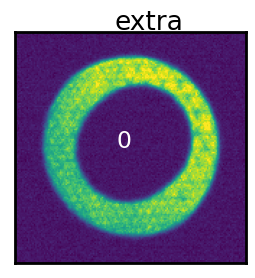

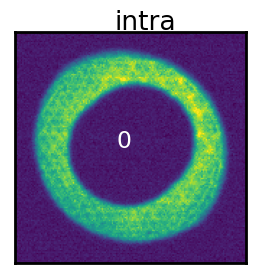

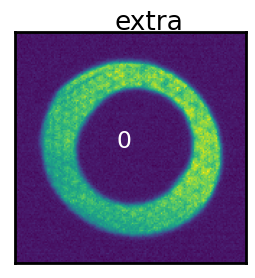

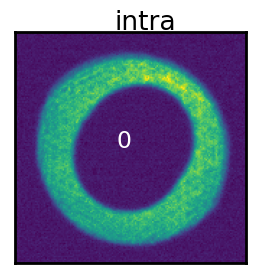

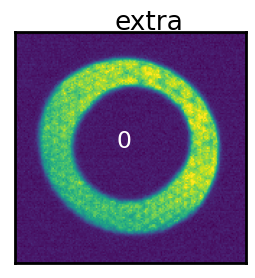

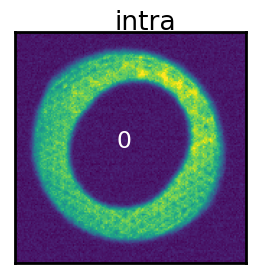

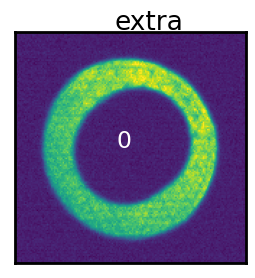

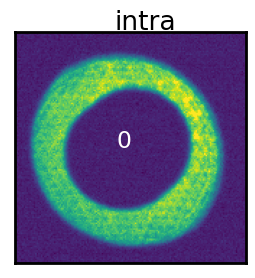

In [19]:
for sensor in ['R00','R04','R40','R44']:
    donutStamps = detectorDonutsExtra[sensor]
    func.plot_stamps( donutStamps, 'extra', N=len(donutStamps), 
                panel_width=3)
    
    donutStamps = detectorDonutsIntra[sensor]
    func.plot_stamps( donutStamps, 'intra', N=len(donutStamps), 
                panel_width=3)
    

So it looks like when we run `imgCloseLoop` nothing is broken ... 

    cp /sdf/data/rubin/u/scichris/WORK/AOS/DM-36218/


the sky file needs to have a format of 


    # Id Ra Decl Mag
    0 -1.0767777777777778 -1.0838055555555555 15
    1 -1.0767777777777778 -1.0971388888888889 15
    2 -1.0767777777777778 -1.110472222222222 15
    3 -1.0767777777777776 -1.1238055555555555 15
    4 -1.0767777777777778 -1.137138888888889 15
    5 -1.0767777777777778 -1.1504722222222221 15
    6 -1.0767777777777776 -1.1638055555555555 15

So I need to change the refcat 

     /sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/ts_wep/tests/testData/skyRefCat.txt

so that instead of 

    id,ra,dec,g,g_err
    0,0.066372,0.098209,15.0,0.1
    1,0.010816,0.042642,15.0,0.1
    2,359.910819,-0.079605,15.0,0.1
    3,359.910818,-0.074048,17.5,0.1
    4,0.066365,-0.136985,15.0,0.1
    5,0.010787,-0.192528,15.0,0.1

it is more like the above. This necessitates the change in `ra` column, because we see that the one in refcat goes 0 to 360, whereas phosim goes from -180,+180...



Next:

    - rewrite the refcat file, save as input skyfile
    - run imgCloseLoop specifying the skyfile
    - check if it converges, AND what is the location / WCS of the newly created images ... 
    
    
    


In [21]:
from astropy.table import Table
skyCat = '/sdf/data/rubin/gpfs/ncsa-home/home/scichris/aos/ts_wep/tests/testData/skyRefCat.txt'
sky = Table.read(skyCat, format='ascii')

In [23]:
m = sky['ra'] > 180
sky['ra'][m] = sky['ra'][m]-360.

In [27]:
# id  --> Id 
# ra --> Ra
# dec --> Decl
# g --> Mag 
names = ['id','ra','dec','g']
new_names = ['Id','Ra','Decl','Mag']
sky.rename_columns(names, new_names)

In [29]:
fname = '/sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/skyRefCat_format.txt'

In [30]:
sky[['Id','Ra','Decl','Mag']].write(fname, 
                                       format='ascii.commented_header',
                                      overwrite=True)

Now rerun the imgCloseLoop with 2 cores:
    
    python  /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 200 --boresightDeg 0.0 0.0 --output  /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat/ --skyFile /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/skyRefCat_format.txt
    
    
    
    

Check the output: 

NOTE: I'm getting the following 
    
    lsst.obs.lsst.assembly WARNING: /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat/phosimData/LSSTCam/raw/all/raw/20211231/MC_H_20211231_006010/raw_LSSTCam_g_MC_H_20211231_006010_R00_SW0_LSSTCam_raw_all.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(575, 2047)) v. (minimum=(0, 0), maximum=(543, 2047)))
    
    
this could be because overscan got changed in `obs_lsst`. 

Perhaps need to update the `phosim_syseng4` code  - opened a ticket https://jira.lsstcorp.org/browse/DM-37128 

In [1]:
import algoritm_functions as func

repo_dir = '/sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat/phosimData/'
instrument = 'LSSTCam'
collection = 'ts_phosim_9006000'

detectorDonutsExtra = {}
detectorDonutsIntra = {}

for sensor in ['R00','R04','R40','R44']:

    # read in all the donuts 
    donutStampsExtra, extraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW0",
                                          dataset_type = 'donutStampsExtra', 
                                          collection=collection)

    donutStampsIntra, intraFocalCatalog = func.get_butler_stamps(repo_dir,instrument=instrument, 
                                          iterN=0, detector=f"{sensor}_SW1",
                                          dataset_type = 'donutStampsIntra', 
                                          collection=collection)

    detectorDonutsExtra[sensor] = donutStampsExtra
    detectorDonutsIntra[sensor] = donutStampsIntra


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


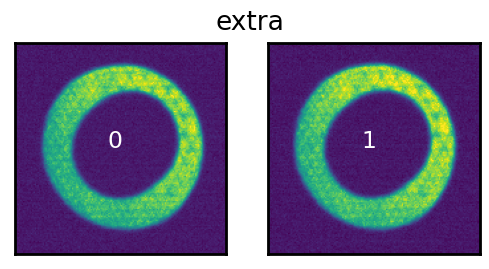

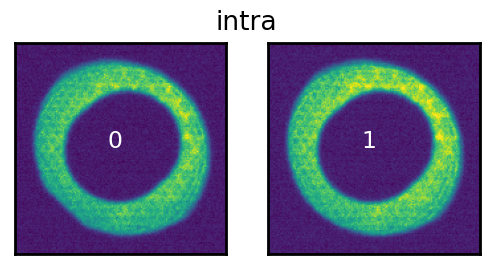

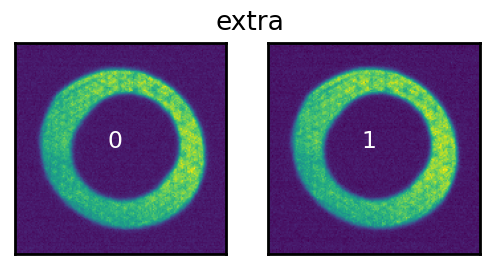

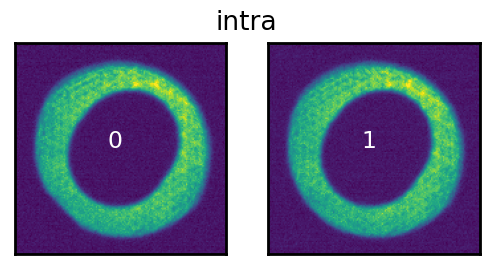

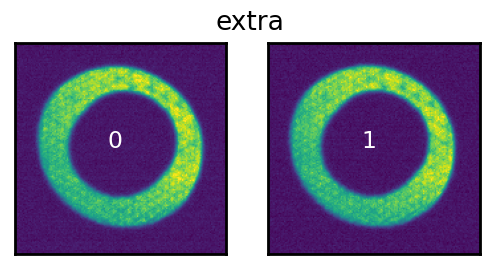

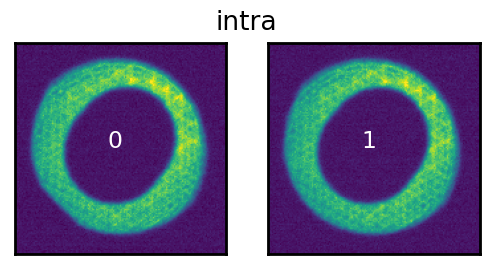

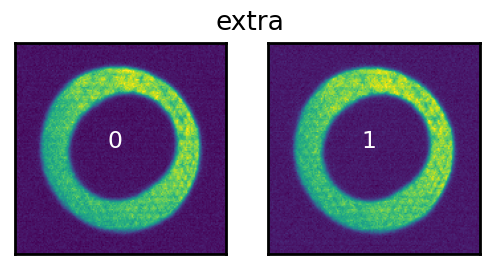

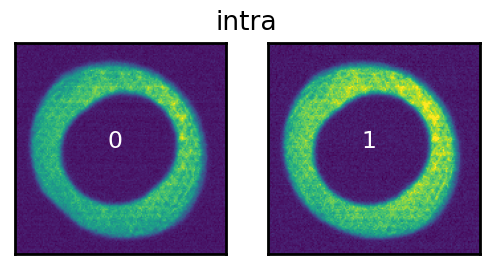

In [2]:
import algoritm_functions as func
for sensor in ['R00','R04','R40','R44']:
    donutStamps = detectorDonutsExtra[sensor]
    func.plot_stamps( donutStamps, 'extra', N=len(donutStamps), 
                panel_width=3)
    
    donutStamps = detectorDonutsIntra[sensor]
    func.plot_stamps( donutStamps, 'intra', N=len(donutStamps), 
                panel_width=3)
    

Run after the overscan update (DM-37130):
     
        
        
        python  /sdf/group/rubin/ncsa-home/home/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst lsst --numOfProc 200 --boresightDeg 0.0 0.0 --output  /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat_overscan/ --skyFile /sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/skyRefCat_format.txt
        
        
this is slurm job 1405784 

# Plot the iteration summary

In [3]:
import analysis_tools as at 

Saved fig as 1.png


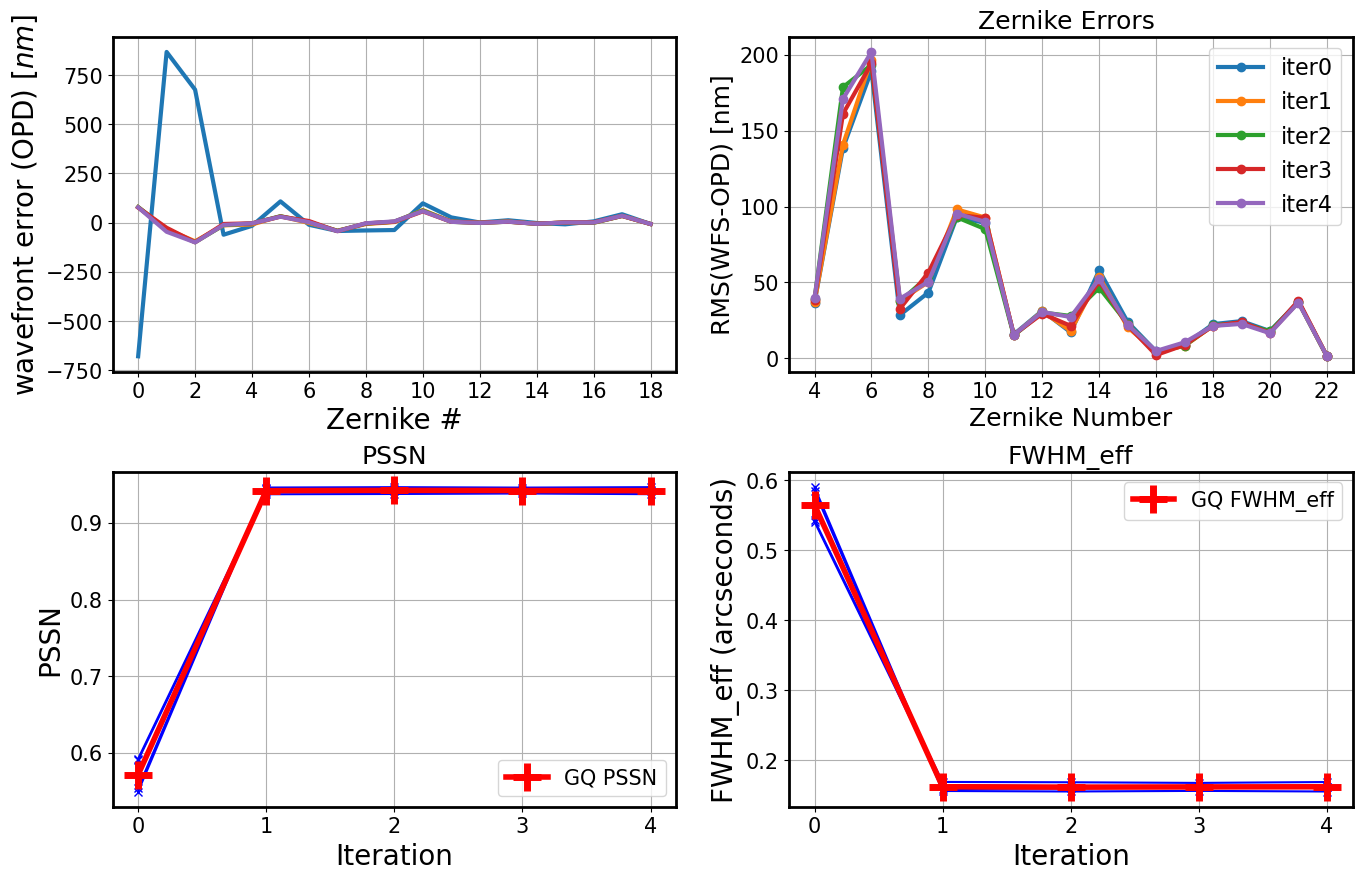

In [11]:
at.plotIterationSummary('/sdf/data/rubin/u/scichris/WORK/AOS/DM-37063/imgCloseLoop_wfs_skyRefCat_overscan/',
                       iterNum=5, num_ccds=4,
                       plot_aos_fwhm_line=False)